x_img: batch_size, None, None, 3

x_roi: batch_size, num_rois, 4

---
y_pred_cls: batch_size, num_rois, nb_classes

y_pred_reg: batch_size, num_rois, 4*(nb_classes-1)

---
y_true_cls: batch_size, num_rois, nb_classes

y_true_reg: batch_size, num_rois, 4+1 (for region state 1 for positive, 0 for 
negative)



# Config

In [89]:
# import the necessary packages
import os

# config
ORIG_BASE_PATH = '/content/drive/MyDrive/fast_rcnn/INRIAPerson'
ORIG_TRAIN_ANNOT_PATH = os.path.sep.join([ORIG_BASE_PATH, "Train/annotations"])
ORIG_TEST_ANNOT_PATH = os.path.sep.join([ORIG_BASE_PATH, "Test/annotations"])
ORIG_TRAIN_POS_PATH = os.path.sep.join([ORIG_BASE_PATH, "Train/pos"])
ORIG_TEST_POS_PATH = os.path.sep.join([ORIG_BASE_PATH, "Test/pos"])

BASE_PATH = "/content/drive/MyDrive/fast_rcnn/dataset"
TRAIN_PATH = os.path.sep.join([BASE_PATH, "Train"])
TRAIN_POS_PATH = os.path.sep.join([BASE_PATH, "Train/pos"])
TRAIN_NEG_PATH = os.path.sep.join([BASE_PATH, "Train/neg"])
TEST_PATH = os.path.sep.join([BASE_PATH, "Test"])
TEST_POS_PATH = os.path.sep.join([BASE_PATH, "Test/pos"])
TEST_NEG_PATH = os.path.sep.join([BASE_PATH, "Test/neg"])
TRAIN_PROPOSALS_PATH = os.path.sep.join([TRAIN_PATH, "proposals.pkl"])
TEST_PROPOSALS_PATH = os.path.sep.join([TEST_PATH, "proposals.pkl"])


MAX_PROPOSALS = 2000
MAX_PROPOSALS_INFER = 200
INPUT_DIMS = (1024, 1024)

BATCH_SIZE = 48
MAX_POSITIVE = int(BATCH_SIZE*0.25)
MAX_NEGATIVE = BATCH_SIZE - MAX_POSITIVE

MODEL_PATH = "/content/drive/MyDrive/fast_rcnn/models"
PLOT_PATH = "/content/drive/MyDrive/fast_rcnn/plots"
LOG_PATH = "/content/drive/MyDrive/fast_rcnn/logs"

MIN_PROBA = 0.9

# Utils

In [90]:
def compute_iou(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the intersection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

In [91]:
def compute_transformation(proposedRect, gtBox):
  (propStartX, propStartY, propEndX, propEndY) = proposedRect
  pX = (propStartX + propEndX) / 2
  pY = (propStartY + propEndY) / 2
  pW = propEndX - propStartX
  pH = propEndY - propStartY

  (gtStartX, gtStartY, gtEndX, gtEndY) = gtBox
  gX = (gtStartX + gtEndX) / 2
  gY = (gtStartY + gtEndY) / 2
  gW = gtEndX - gtStartX
  gH = gtEndY - gtStartY

  tX = (gX - pX) / pW
  tY = (gY - pY) / pH
  tW = math.log(gW/pW)
  tH = math.log(gH/pH)

  return [tY, tX, tH, tW]

In [92]:
def read_annotFile(annotPath):
    # initialize the image dimensions and list of ground-truth bounding boxes
    w, h = 0, 0
    gtBoxes = []
    with open(annotPath, 'r', encoding='latin-1') as f:
      lines = f.readlines()
      for line in lines:
        # extract the image dimensions
        if 'Image size (X x Y x C)' in line:
          _ = line.split(':')[1].strip().split('x')
          w = int(_[0].strip())
          h = int(_[1].strip())
        # extract ground-truth bounding boxes
        elif 'Bounding box for object' in line:
          _ = [e.strip().split(',') for e in line.split(':')[1].split('-')]
          xMin = int(_[0][0].strip()[1:])
          yMin = int(_[0][1].strip()[:-1])
          xMax = int(_[1][0].strip()[1:])
          yMax = int(_[1][1].strip()[:-1])
          gtBox = xMin, yMin, xMax, yMax
          gtBoxes.append(gtBox)
    return w, h, gtBoxes

# Dataset

In [19]:
from imutils import paths

# grab all image paths in the input images directory
train_pos_imagePaths = list(paths.list_images(ORIG_TRAIN_POS_PATH))
test_pos_imagePaths = list(paths.list_images(ORIG_TEST_POS_PATH))

In [ ]:
import cv2
import os
import pickle

def generate_proposals(imgPaths, proposals_path):

  proposals = {}

  for (i, imgPath) in enumerate(imgPaths):
    # show a progress report
    print("[INFO] processing image {}/{}...".format(i + 1, len(imgPaths)))

    # load the input image from disk
    image = cv2.imread(imgPath)

    # run selective search on the image and initialize our list of
    # proposed boxes
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    proposedRects= []

    # loop over the rectangles generated by selective search
    for (x, y, w, h) in rects:
      proposedRects.append((x, y, x + w, y + h))

    proposals[imgPath] = proposedRects
      
  print('[INFO] saving...')
  with open(proposals_path, 'wb') as f:
    pickle.dump(proposals, f, pickle.HIGHEST_PROTOCOL)
  print('[INFO] done')
  
  return

In [67]:
import cv2
import os
import math
import numpy as np
import pickle

def build_dataset(imgPaths, orig_annot_path, data_path, proposals_path):

  x_img = [] # None, None, None, 3
  x_roi = [] # None, num_rois, 4
  y_true_cls = [] # None, num_rois, nb_classes
  y_true_reg = [] # None, num_rois, 5

  proposals = None
  with open(proposals_path, 'rb') as f:
    proposals = pickle.load(f)

  for (i, imgPath) in enumerate(imgPaths):
    # show a progress report
    print("[INFO] processing image {}/{}...".format(i + 1, len(imgPaths)))
    # extract the filename from the file path and use it to derive
    # the path to the txt annotation file
    filename = imgPath.split(os.path.sep)[-1]
    filename = filename[:filename.rfind(".")]
    annotPath = os.path.sep.join([orig_annot_path, "{}.txt".format(filename)])
    
    # read annotation file to extract the image dimensions and groudtruth boxes  
    width, height, gtBoxes = read_annotFile(annotPath)
    # print(' w, h, gtBoxes', (width, height, gtBoxes))
    # load the input image from disk
    image = cv2.imread(imgPath)

    proposedRects = proposals[imgPath]

    positiveROIs = 0
    negativeROIs = 0
    rois = []
    cls = []
    reg = []
    # loop over the maximum number of region proposals
    for proposedRect in proposedRects:
      if len(rois) == BATCH_SIZE:
        break
      (propStartX, propStartY, propEndX, propEndY) = proposedRect
      ious = np.array([compute_iou(gtBox, proposedRect) for gtBox in gtBoxes])
      isNegative1 = np.logical_and(ious > 0.1, 
                                   ious < 0.4).sum() == ious.shape[0]
      isNegative2 = (ious < 0.05).sum() == ious.shape[0]
      if isNegative1 and negativeROIs < MAX_NEGATIVE:
        rois.append((propStartY/height, propStartX/width, 
                     propEndY/height, propEndX/width))
        reg.append([0., 0., 0., 0., 0.])
        cls.append(0)
        negativeROIs += 1
        continue
      elif isNegative2 and positiveROIs > MAX_POSITIVE/3:
        rois.append((propStartY/height, propStartX/width, 
                     propEndY/height, propEndX/width))
        reg.append([0., 0., 0., 0., 0.])
        cls.append(0)
        continue
      # loop over the ground-truth bounding boxes
      for gtBox in gtBoxes:
        (gtStartX, gtStartY, gtEndX, gtEndY) = gtBox
        t = compute_transformation(proposedRect, gtBox)
        iou = compute_iou(gtBox, proposedRect)
        if iou > 0.5:
          rois.append((propStartY/height, propStartX/width, 
                       propEndY/height, propEndX/width))
          t.append(1.)
          reg.append(t)
          cls.append(1)
          positiveROIs += 1

    if len(rois) == BATCH_SIZE:
      image = cv2.resize(image, INPUT_DIMS, interpolation=cv2.INTER_CUBIC)
      x_img.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      rois = np.array(rois)
      cls = np.array(cls)
      reg = np.array(reg)
      inds = np.arange(rois.shape[0])
      np.random.shuffle(inds)
      rois = rois[inds]
      cls = cls[inds]
      reg = reg[inds]
      x_roi.append(rois)
      y_true_cls.append(cls)
      y_true_reg.append(reg)

      
  print('[INFO] Saving...')
  with open(data_path + '/x_img_3.npy', 'wb') as f:
    np.save(f, x_img)
  with open(data_path + '/x_roi_3.npy', 'wb') as f:
    np.save(f, x_roi)
  with open(data_path + '/y_true_cls_3.npy', 'wb') as f:
    np.save(f, y_true_cls)
  with open(data_path + '/y_true_reg_3.npy', 'wb') as f:
    np.save(f, y_true_reg)
    
  return

In [ ]:
generate_proposals(train_pos_imagePaths, TRAIN_PROPOSALS_PATH)

In [ ]:
generate_proposals(test_pos_imagePaths, TEST_PROPOSALS_PATH)

In [ ]:
build_dataset(train_pos_imagePaths, ORIG_TRAIN_ANNOT_PATH, TRAIN_PATH,
              TRAIN_PROPOSALS_PATH)

In [ ]:
build_dataset(test_pos_imagePaths, ORIG_TEST_ANNOT_PATH, TEST_PATH,
              TEST_PROPOSALS_PATH)

# Loss

In [93]:
def smooth_l1(sigma=1.0):
  sigma_squared = sigma ** 2
  def _smooth_l1(y_true, y_pred):
    #---------------------------------------------------#
    #   y_true [batch_size, num_anchor, 4+1]
    #   y_pred [batch_size, num_anchor, 4*(nb_classes - 1)]
    #---------------------------------------------------#
    y_pred_shape = tf.shape(y_pred)
    batch_size = y_pred_shape[0]
    num_rois = y_pred_shape[1]
    # nb_classes = y_pred_shape[2]/4 + 1 # included background
    regression_ = tf.reshape(y_pred, [-1, y_pred_shape[2]])
    regression_target = y_true[:, :, :-1]
    regression_target = tf.reshape(y_true[:, :, :-1], [-1, 4])
    regression = tf.zeros(tf.shape(regression_target), 
                          dtype=tf.keras.backend.floatx())
    roi_class = tf.reshape(y_true[:, :, -1], [-1,])
    n = batch_size*num_rois

    for i in tf.range(n):
      c = int(roi_class[i])
      if tf.math.greater(c, 0):
        regression_i = tf.reshape(regression_[i][(c-1)*4:c*4], [1,4])
        # regression[i] = regression_i
        regression = tf.tensor_scatter_nd_update(regression, [[i]], 
                                                 regression_i)
      # print(regression)
    regression_diff = regression - regression_target
    regression_diff = tf.math.abs(regression_diff)
    regression_loss = tf.where(
        tf.math.less(regression_diff, 1.0 / 1.0),
        0.5 * 1.0 * tf.math.pow(regression_diff, 2),
        regression_diff - 0.5 / 1.0
    )
    
    mask = tf.where(tf.math.greater(roi_class, 0), 1. , 0.)
    normalizer = tf.reduce_sum(mask)
    regression_loss = tf.reduce_sum(regression_loss)
    regression_loss = regression_loss / tf.cast(normalizer, 
                                                dtype=tf.keras.backend.floatx())

    return regression_loss 
  return _smooth_l1

# Test Loss

In [ ]:
# Test CategoricalCrossentropy
cce = tf.keras.losses.CategoricalCrossentropy()
y_true = np.array([[[1, 0, 0],[1, 0, 0]],
          [[0, 1, 0],[0, 0, 1]],
          [[1, 0, 0],[0, 1, 0]],
          [[0, 0, 1],[1, 0, 0]]])
y_pred = np.array([[[1, 0, 0],[1, 0, 0]],
          [[0, 1, 0],[0, 0, 1]],
          [[1, 0, 0],[0.2, 0.8, 0]],
          [[0, 0, 1],[1, 0, 0]]])
#print(y_true.shape)
print(cce(y_true, y_pred))

tf.Tensor(0.027893031015992165, shape=(), dtype=float64)


In [ ]:
y_true = np.array([[[0.4, 0.5, 0.3, 0.6, 1.], [0., 0., 0., 0., 0.]],
                   [[0.4, 0.5, 0.3, 0.6, 2.], [0.5, 0.5, 0.5, 0.5, 1.]]], dtype=np.float32)
y_pred = np.array([[[0.1, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3], [0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3]],
                   [[0.3, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3], [0.4, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3]]], dtype=np.float32)

smooth_l1()(y_true, y_pred)

tf.Tensor(
[[0.1 0.2 0.2 0.2]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]], shape=(4, 4), dtype=float32)
tf.Tensor(
[[0.1 0.2 0.2 0.2]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]], shape=(4, 4), dtype=float32)
tf.Tensor(
[[0.1 0.2 0.2 0.2]
 [0.  0.  0.  0. ]
 [0.3 0.3 0.3 0.3]
 [0.  0.  0.  0. ]], shape=(4, 4), dtype=float32)
tf.Tensor(
[[0.1 0.2 0.2 0.2]
 [0.  0.  0.  0. ]
 [0.3 0.3 0.3 0.3]
 [0.4 0.2 0.2 0.2]], shape=(4, 4), dtype=float32)


<tf.Tensor: shape=(), dtype=float32, numpy=0.12833335>

# Model

In [94]:
import tensorflow as tf

class RoiPooling(tf.keras.layers.Layer):
  def __init__(self, pool_size, **kwargs):
    super(RoiPooling, self).__init__(**kwargs)
    self.pool_size = pool_size

  def build(self, input_shape):
    self.nb_channels = input_shape[0][3]

  def compute_output_shape(self, input_shape):
    # (batch_size, num_rois, pool_size, pool_size, nb_channels)
    return tf.TensorShape((None, input_shape[1][1], self.pool_size, self.pool_size, 
            self.nb_channels))
  
  def call(self, x):
    assert(len(x) == 2)
    feature_map = x[0] # (batch_size, H, W, nb_channels)
    rois = x[1] # (batch_size, num_rois, 4)
    num_rois = tf.shape(rois)[1]
    batch_size = tf.shape(rois)[0]

    # [[0], [1],..., [batch_size-1]] 
    # shape (batch_size,1)
    box_index = tf.expand_dims(tf.range(0, batch_size), 1)
    # [[0,..., 0], [1,..., 1],..., [batch_size-1,..., batch_size-1]]
    # shape (batch_size, num_rois)
    box_index = tf.tile(box_index, (1, num_rois))
    # [0,..., 0, 1,..., 1,..., batch_size-1,..., batch_size-1]
    # shape (batch_size, num_rois)
    box_index = tf.reshape(box_index, [-1])
    # shape (batch_size x num_rois, pool_size, pool_size, nb_channels)
    rs = tf.image.crop_and_resize(feature_map, tf.reshape(rois, [-1,4]), 
                                  box_index, (self.pool_size, self.pool_size))
    final_output = tf.reshape(rs, (batch_size, num_rois, self.pool_size, 
                                   self.pool_size, self.nb_channels))
    # final_output = tf.ensure_shape(final_output, 
    #                                (None, num_rois, self.pool_size, 
    #                                 self.pool_size, self.nb_channels))
    return final_output

  def get_config(self):
    config = super(RoiPooling, self).get_config()
    config.update({"pool_size": self.pool_size})
    return config

In [95]:
from tensorflow.keras.layers import (Conv2D, Dense, Flatten, Input, Reshape, 
                                     TimeDistributed, AveragePooling2D,
                                     Activation, BatchNormalization, Add, 
                                     Dropout)
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import HeNormal

def get_fast_rcnn_model(pool_size, nb_classes, num_rois):

  ################################### Input ###################################
  img_inputs = Input(shape=(1024, 1024, 3))
  roi_inputs = Input(shape=(num_rois, 4))

  ############################# Transfer Learning #############################
  baseModel = ResNet50(weights="imagenet", include_top=False, 
                          input_shape=(1024, 1024, 3))
  # for layer in baseModel.layers:
  #   layer.trainable = False
  baseModel = Model(inputs=baseModel.input, 
                    outputs=baseModel.get_layer('conv4_block6_out').output)

  ############################# Feature Extraction #############################
  # input: batch_size, 1024, 1024, 3 
  # output: batch_size, 64, 64, 1024
  base_feature_map = baseModel(preprocess_input(img_inputs))

  ################################ Roi Pooling #################################
  # input: batch_size, 64, 64, 1024 and batch_size, num_rois, 4
  # output: batch_size, num_rois, pool_size, pool_size, 1024 
  roi_pool = RoiPooling(pool_size)([base_feature_map, roi_inputs])

  ######################### ResNet50's Stage-5 Blocks #########################
  # input: batch_size, num_rois, pool_size, pool_size, 1024 
  # output: batch_size, num_rois, pool_size/2, pool_size/2, 2048

  # convolutional block 1
  x = TimeDistributed(Conv2D(512, 1, strides=2, 
                             kernel_initializer=HeNormal()),
                      name='conv_block_a')(roi_pool)
  x = TimeDistributed(BatchNormalization(),
                      name='conv_block_bn_a')(x)
  x = Activation('relu')(x)

  x = TimeDistributed(Conv2D(512, 3, padding='same', 
                             kernel_initializer=HeNormal()),
                      name='conv_block_b')(x)
  x = TimeDistributed(BatchNormalization(),
                      name='conv_block_bn_b')(x)
  x = Activation('relu')(x)

  x = TimeDistributed(Conv2D(2048, 1, 
                             kernel_initializer=HeNormal()),
                      name='conv_block_c')(x)
  x = TimeDistributed(BatchNormalization(),
                      name='conv_block_bn_c')(x)

  shortcut = TimeDistributed(Conv2D(2048, 1, strides=2, 
                                    kernel_initializer=HeNormal()),
                             name='conv_block_shortcut')(roi_pool)
  shortcut = TimeDistributed(BatchNormalization(),
                             name='conv_block_bn')(shortcut)

  x = Add()([x, shortcut])
  x = Activation('relu')(x)

  # identity block 1
  x_ = x
  x = TimeDistributed(Conv2D(512, 1, 
                             kernel_initializer=HeNormal()),
                      name='iden_block_1a')(x)
  x = TimeDistributed(BatchNormalization(),
                      name='iden_block_bn_1a')(x)
  x = Activation('relu')(x)

  x = TimeDistributed(Conv2D(512, 3, padding='same', 
                             kernel_initializer=HeNormal()),
                      name='iden_block_1b')(x)
  x = TimeDistributed(BatchNormalization(),
                      name='iden_block_bn_1b')(x)
  x = Activation('relu')(x)

  x = TimeDistributed(Conv2D(2048, 1, 
                             kernel_initializer=HeNormal()),
                      name='iden_block_1c')(x)
  x = TimeDistributed(BatchNormalization(),
                      name='iden_block_bn_1c')(x)

  x = Add()([x, x_])
  x = Activation('relu')(x)

  # identity block 2
  x_ = x
  x = TimeDistributed(Conv2D(512, 1, 
                             kernel_initializer=HeNormal()),
                      name='iden_block_2a')(x)
  x = TimeDistributed(BatchNormalization(),
                      name='iden_block_bn_2a')(x)
  x = Activation('relu')(x)

  x = TimeDistributed(Conv2D(512, 3, padding='same', 
                             kernel_initializer=HeNormal()),
                      name='iden_block_2b')(x)
  x = TimeDistributed(BatchNormalization(),
                      name='iden_block_bn_2b')(x)
  x = Activation('relu')(x)

  x = TimeDistributed(Conv2D(2048, 1, 
                             kernel_initializer=HeNormal()),
                      name='iden_block_2c')(x)
  x = TimeDistributed(BatchNormalization(),
                      name='iden_block_bn_2c')(x)

  x = Add()([x, x_])
  x = Activation('relu')(x)

  ############################## Feature Vectors ##############################
  # input: batch_size, num_rois, pool_size/2, pool_size/2, 2048 
  # output: batch_size, num_rois, 1, 1, 2048
  x = TimeDistributed(AveragePooling2D(int(pool_size/2)), 
                      name='avg_pool')(x)

  x = TimeDistributed(Flatten())(x)
  x = TimeDistributed(Dropout(0.2), name='dropout')(x)

  ############################### Classification ###############################
  # input: batch_size, num_rois, 2048
  # output: batch_size, num_rois, nb_classes
  x_cls = TimeDistributed(Dense(nb_classes, activation='softmax'), 
                          name='cls')(x)

  ################################# Regression #################################
  # input: batch_size, num_rois, 640
  # output: batch_size, num_rois, 4*(nb_classes-1)
  x_reg = TimeDistributed(Dense(4*(nb_classes-1), activation='linear'), 
                          name='reg')(x)

  model = Model(inputs=[img_inputs, roi_inputs], outputs=[x_cls, x_reg])
  return model


# Training

In [87]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [88]:
%%bash
cd /content/drive/MyDrive/fast_rcnn/logs
rm -r *

In [ ]:
%tensorboard --logdir /content/drive/MyDrive/fast_rcnn/logs

In [72]:
# read dataset
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
x_img = None
x_roi = None
y_true_cls = None
y_true_reg = None

with open(os.path.sep.join([TRAIN_PATH, "x_img_3.npy"]), 'rb') as f:
  x_img = np.load(f)
with open(os.path.sep.join([TRAIN_PATH, "x_roi_3.npy"]), 'rb') as f:
  x_roi = np.load(f)
with open(os.path.sep.join([TRAIN_PATH, "y_true_cls_3.npy"]), 'rb') as f:
  y_true_cls = np.load(f)
with open(os.path.sep.join([TRAIN_PATH, "y_true_reg_3.npy"]), 'rb') as f:
  y_true_reg = np.load(f)

y_true_cls = to_categorical(y_true_cls)

In [73]:
x_roi.shape

(537, 48, 4)

In [74]:
def get_lr_metric(optimizer):
  def lr(y_true, y_pred):
      return optimizer.lr
  return lr

In [85]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import (Precision, Recall, TruePositives,
                                      FalsePositives, TrueNegatives,
                                      FalseNegatives, CategoricalAccuracy)
from tensorflow.keras.callbacks import (TensorBoard, ReduceLROnPlateau)
import datetime, os

pool_size = 14
nb_classes = 2
num_rois = None
epochs = 20
batch_size = 8
validation_split = 0.2
lr = 1e-4

loss = {'cls' : CategoricalCrossentropy(), 
          'reg' : smooth_l1(1.0)}
optimizer = Adam(lr=lr)
lr_metric = get_lr_metric(optimizer)
metrics = {'cls': [CategoricalAccuracy(name='accuracy'), 
                         Precision(thresholds=0.9, name='precision'), 
                         Recall(thresholds=0.9, name='recall'),
                         TruePositives(thresholds=0.9, name='tp'), 
                         FalsePositives(thresholds=0.9, name='fp'),
                         TrueNegatives(thresholds=0.9, name='tn'), 
                         FalseNegatives(thresholds=0.9, name='fn'),
                         lr_metric]}
logdir = os.path.join(LOG_PATH, 
                      datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)
reduce_lr = ReduceLROnPlateau(monitor='val_cls_loss', factor=0.9,
                              patience=2, min_lr=1e-6)
callbacks = [tensorboard_callback, reduce_lr]
model = get_fast_rcnn_model(pool_size, nb_classes, num_rois)
model.compile(loss=loss, metrics=metrics,
              optimizer=optimizer)
history = model.fit(x=[x_img, x_roi], y=[y_true_cls, y_true_reg], 
                    validation_split=validation_split, batch_size=batch_size, 
                    epochs=epochs, callbacks=callbacks)

Epoch 1/100
108/108 [==============================] - 82s 688ms/step - loss: 1.5809 - cls_loss: 0.3507 - reg_loss: 1.2302 - cls_accuracy: 0.8754 - cls_precision: 0.9353 - cls_recall: 0.6160 - cls_tp: 6353.0275 - cls_fp: 375.8532 - cls_tn: 10179.7431 - cls_fn: 4202.5688 - cls_lr: 1.0000e-04 - val_loss: 1.4216 - val_cls_loss: 0.4368 - val_reg_loss: 0.9847 - val_cls_accuracy: 0.8902 - val_cls_precision: 0.8976 - val_cls_recall: 0.8623 - val_cls_tp: 4470.0000 - val_cls_fp: 510.0000 - val_cls_tn: 4674.0000 - val_cls_fn: 714.0000 - val_cls_lr: 1.0000e-04
Epoch 2/100
108/108 [==============================] - 70s 644ms/step - loss: 0.5276 - cls_loss: 0.2799 - reg_loss: 0.2477 - cls_accuracy: 0.8858 - cls_precision: 0.9792 - cls_recall: 0.5441 - cls_tp: 5886.6606 - cls_fp: 114.4862 - cls_tn: 10441.1101 - cls_fn: 4668.9358 - cls_lr: 1.0000e-04 - val_loss: 0.5776 - val_cls_loss: 0.3262 - val_reg_loss: 0.2515 - val_cls_accuracy: 0.8908 - val_cls_precision: 0.9213 - val_cls_recall: 0.8154 - val_c

In [33]:
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_12 (Sl (None, 1024, 1024, 3 0           input_37[0][0]                   
__________________________________________________________________________________________________
tf.nn.bias_add_12 (TFOpLambda)  (None, 1024, 1024, 3 0           tf.__operators__.getitem_12[0][0]
__________________________________________________________________________________________________
resnet101 (Functional)          (None, 32, 32, 2048) 42658176    tf.nn.bias_add_12[0][0]          
___________________________________________________________________________________________

In [86]:
# saving model
model.save(os.path.sep.join([MODEL_PATH, 
                             "fast_rcnn_resnet50_1024_1024.h5"]), 
                             save_format="h5")

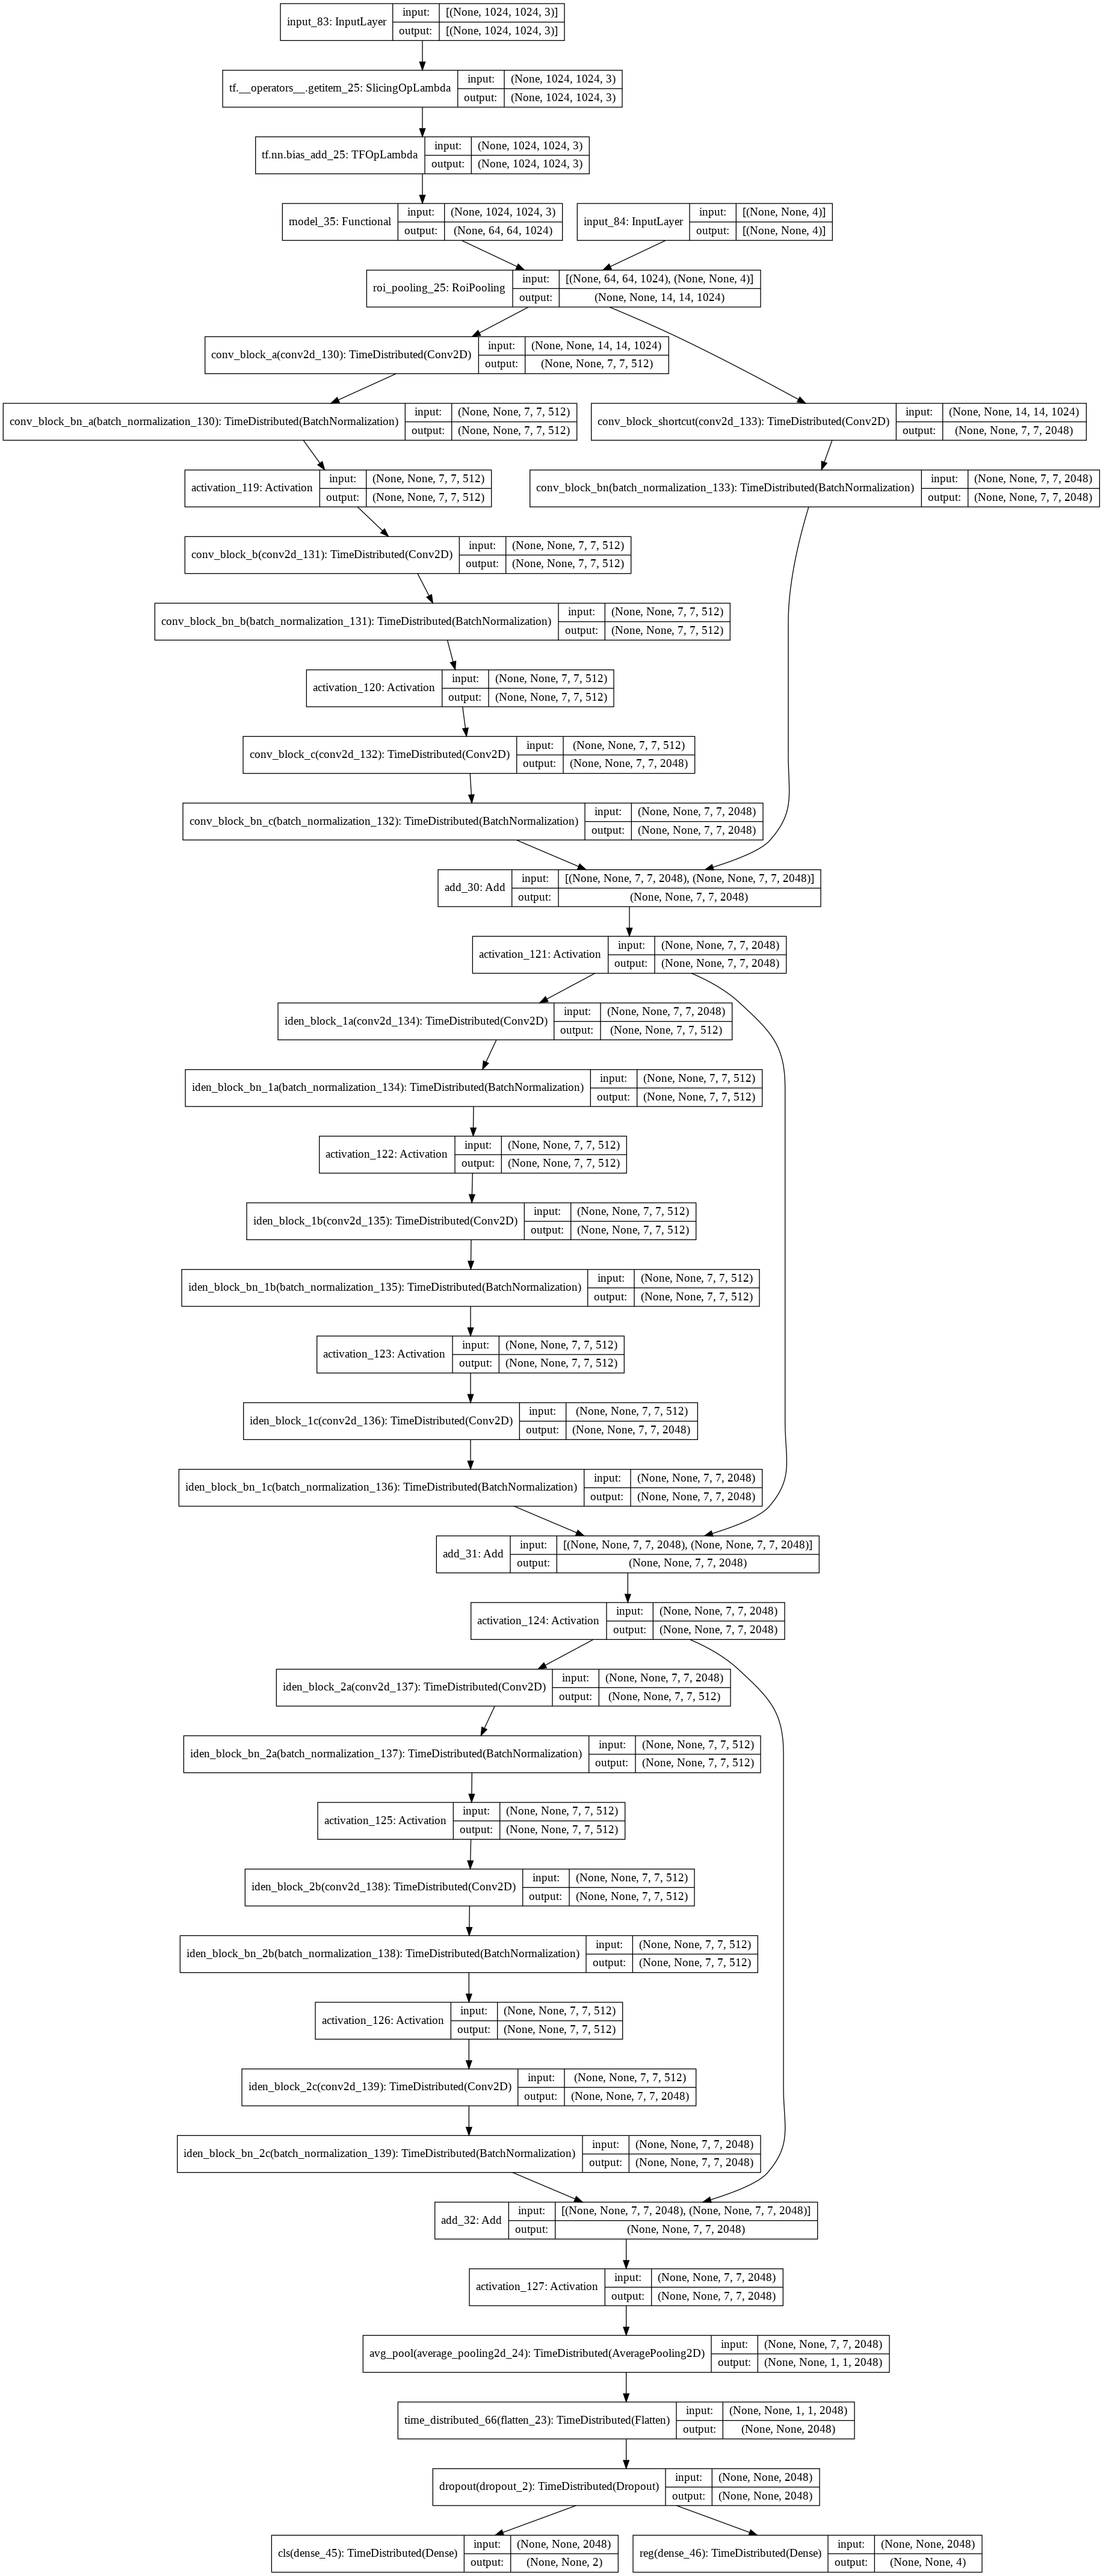

In [100]:
tf.keras.utils.plot_model(
    model,
    to_file="fast_rcnn_resnet50_1024_1024.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

# Evaluation

In [96]:
from tensorflow.keras.models import load_model

print("[INFO] loading model...")
model = load_model(os.path.sep.join([MODEL_PATH, 
                                    'fast_rcnn_resnet50_1024_1024.h5']),
                   custom_objects={'RoiPooling': RoiPooling, 
                                   '_smooth_l1': smooth_l1(),
                                   'lr': get_lr_metric(Adam())})
print("[INFO] done")

[INFO] loading model...


In [98]:
# read dataset
import numpy as np
from tensorflow.keras.utils import to_categorical

x_img_test = None
x_roi_test = None
y_true_cls_test = None
y_true_reg_test = None

with open(os.path.sep.join([TEST_PATH, "x_img_3.npy"]), 'rb') as f:
  x_img_test = np.load(f)
with open(os.path.sep.join([TEST_PATH, "x_roi_3.npy"]), 'rb') as f:
  x_roi_test = np.load(f)
with open(os.path.sep.join([TEST_PATH, "y_true_cls_3.npy"]), 'rb') as f:
  y_true_cls_test = np.load(f)
with open(os.path.sep.join([TEST_PATH, "y_true_reg_3.npy"]), 'rb') as f:
  y_true_reg_test = np.load(f)

y_true_cls_test = to_categorical(y_true_cls_test)

inds = np.arange(x_img_test.shape[0])
np.random.shuffle(inds)

x_img_test = x_img_test[inds]
x_roi_test = x_roi_test[inds]
y_true_cls_test = y_true_cls_test[inds]
y_true_reg_test = y_true_reg_test[inds]

In [99]:
# evaluating
model.evaluate(x=[x_img_test, x_roi_test], 
               y=[y_true_cls_test, y_true_reg_test])

9/9 [==============================] - 15s 1s/step - loss: 0.1971 - cls_loss: 0.1595 - reg_loss: 0.0376 - cls_cls_accuracy: 0.9625 - cls_cls_precision: 0.9770 - cls_cls_recall: 0.9440 - cls_cls_tp: 11826.0000 - cls_cls_fp: 279.0000 - cls_cls_tn: 12249.0000 - cls_cls_fn: 702.0000 - cls_cls_lr: 0.0010


[0.19705969095230103,
 0.1594933718442917,
 0.03756631165742874,
 0.9624840617179871,
 0.9769516587257385,
 0.943965494632721,
 11826.0,
 279.0,
 12249.0,
 702.0,
 0.0010000000474974513]

# Inference

In [ ]:
from tensorflow.keras.models import load_model

print("[INFO] loading model...")
model = load_model(os.path.sep.join([MODEL_PATH, 
                                    'fast_rcnn_resnet50_1024_1024.h5']),
                   custom_objects={'RoiPooling': RoiPooling, 
                                   '_smooth_l1': smooth_l1(),
                                   'lr': get_lr_metric(Adam())})
print("[INFO] done")

In [104]:
from imutils import paths

# grab all image paths in the input images directory
train_pos_imagePaths = list(paths.list_images(ORIG_TRAIN_POS_PATH))
test_pos_imagePaths = list(paths.list_images(ORIG_TEST_POS_PATH))

In [103]:
from google.colab.patches import cv2_imshow
import numpy as np
import cv2
import math

image = cv2.imread('/content/drive/MyDrive/fast_rcnn/INRIAPerson/Test/pos/crop001593.png')
image = cv2.resize(image, INPUT_DIMS, interpolation=cv2.INTER_CUBIC)
cv2_imshow(image)

print("[INFO] running selective search...")
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
rects = ss.process()

x_roi_ = []
x_img_ = np.expand_dims(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), axis=0)
for (x, y, w, h) in rects[:MAX_PROPOSALS]:
  x_roi_.append((y, x, y + h, x + w))
x_roi_ = np.array(x_roi_)/INPUT_DIMS[0]
x_roi_ = np.expand_dims(x_roi_, axis=0)

print("[INFO] detecting objects...")
y_pred_cls, y_pred_reg = model.predict(x=[x_img_, x_roi_])

y_pred_cls = np.squeeze(y_pred_cls)
y_pred_reg = np.squeeze(y_pred_reg)
x_roi_ = np.squeeze(x_roi_)

mask = y_pred_cls[:, 1] > MIN_PROBA
rois = x_roi_[mask]
transformations = y_pred_reg[mask]
proba = y_pred_cls[mask][:, 1]

print('[INFO] before transforming and NMS ...')
clone = image.copy()
for roi in rois:
  roi = roi*INPUT_DIMS[0]
  roi = roi.astype(int)
  cv2.rectangle(clone, (roi[1], roi[0]), (roi[3], roi[2]), (0, 255, 0), 1)
cv2_imshow(clone)

print('[INFO] after transforming ...')
transformed_rois = []
clone = image.copy()
for i, roi in enumerate(rois):
  roi = roi*INPUT_DIMS[0]
  pX = (roi[1] + roi[3]) / 2
  pY = (roi[0] + roi[2]) / 2
  pW = roi[3] - roi[1]
  pH = roi[2] - roi[0]
  gX = pW*transformations[i][1] + pX
  gY = pH*transformations[i][0] + pY
  gW = pW*math.exp(transformations[i][3])
  gH = pH*math.exp(transformations[i][2])

  startX = int(gX - gW/2)
  startY = int(gY - gH/2)
  endX = int(gX + gW/2)
  endY = int(gY + gH/2)
  transformed_rois.append((startY, startX, endY, endX))
  cv2.rectangle(clone, (startX, startY), (endX, endY), (0, 255, 0), 1)
cv2_imshow(clone)

print('[INFO] after NMS ...')
transformed_rois = np.array(transformed_rois)
idxs = tf.image.non_max_suppression(
    transformed_rois, proba, max_output_size=5, iou_threshold=0.3).numpy()
clone = image.copy()
transformed_rois_nms = transformed_rois[idxs]
proba_nms = proba[idxs]
for i, roi in enumerate(transformed_rois_nms):
  startX = roi[1]
  startY = roi[0]
  endX = roi[3]
  endY = roi[2]
  cv2.rectangle(clone, (startX, startY), (endX, endY), (0, 255, 0), 2)
  y = startY - 10 if startY - 10 > 10 else startY + 10
  text= "Human: {:.2f}%".format(proba_nms[i] * 100)
  cv2.putText(clone, text, (startX, y), 
             cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
cv2_imshow(clone)

Output hidden; open in https://colab.research.google.com to view.

In [112]:
from google.colab.patches import cv2_imshow
import numpy as np
import cv2
import math
import time

for imgPath in test_pos_imagePaths:
  image = cv2.imread(imgPath)
  image = cv2.resize(image, INPUT_DIMS, interpolation=cv2.INTER_CUBIC)

  print("[INFO] running selective search...")
  start = time.time()
  ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
  ss.setBaseImage(image)
  ss.switchToSelectiveSearchFast()
  rects = ss.process()
  end = time.time()
  print("[INFO] took {} seconds".format(end-start))

  x_roi_ = []
  x_img_ = np.expand_dims(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), axis=0)
  for (x, y, w, h) in rects[:MAX_PROPOSALS]:
    x_roi_.append((y, x, y + h, x + w))
  x_roi_ = np.array(x_roi_)/INPUT_DIMS[0]
  x_roi_ = np.expand_dims(x_roi_, axis=0)

  print("[INFO] detecting objects...")
  start = time.time()
  y_pred_cls, y_pred_reg = model.predict(x=[x_img_, x_roi_])

  y_pred_cls = np.squeeze(y_pred_cls)
  y_pred_reg = np.squeeze(y_pred_reg)
  x_roi_ = np.squeeze(x_roi_)

  mask = y_pred_cls[:, 1] > MIN_PROBA
  rois = x_roi_[mask]
  transformations = y_pred_reg[mask]
  proba = y_pred_cls[mask][:, 1]

  transformed_rois = []
  for i, roi in enumerate(rois):
    roi = roi*INPUT_DIMS[0]
    pX = (roi[1] + roi[3]) / 2
    pY = (roi[0] + roi[2]) / 2
    pW = roi[3] - roi[1]
    pH = roi[2] - roi[0]
    gX = pW*transformations[i][1] + pX
    gY = pH*transformations[i][0] + pY
    gW = pW*math.exp(transformations[i][3])
    gH = pH*math.exp(transformations[i][2])
    startX = int(gX - gW/2)
    startY = int(gY - gH/2)
    endX = int(gX + gW/2)
    endY = int(gY + gH/2)
    transformed_rois.append((startY, startX, endY, endX))

  if len(transformed_rois) > 0:
    transformed_rois = np.array(transformed_rois)
    idxs = tf.image.non_max_suppression(
        transformed_rois, proba, max_output_size=5, iou_threshold=0.3).numpy()
    clone = image.copy()
    clone = cv2.resize(image, (200, 200), interpolation=cv2.INTER_CUBIC)
    ratio = INPUT_DIMS[0]/200
    transformed_rois_nms = transformed_rois[idxs]/ratio
    proba_nms = proba[idxs]
    for i, roi in enumerate(transformed_rois_nms.astype(int)):
      startX = roi[1]
      startY = roi[0]
      endX = roi[3]
      endY = roi[2]
      cv2.rectangle(clone, (startX, startY), (endX, endY), (0, 255, 0), 2)
      y = startY - 10 if startY - 10 > 10 else startY + 10
      text= "Human: {:.2f}%".format(proba_nms[i] * 100)
      cv2.putText(clone, text, (startX, y), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
  end = time.time()
  print("[INFO] took {} seconds".format(end-start))
  cv2_imshow(clone)

Output hidden; open in https://colab.research.google.com to view.

# Test RoiPooling

In [ ]:
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
from google.colab.patches import cv2_imshow

image = cv2.imread('/content/drive/MyDrive/fast_rcnn/INRIAPerson/Train/pos/crop001001.png')
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
rects = ss.process()

In [ ]:
width = image.shape[1]
height = image.shape[0]

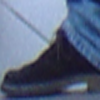

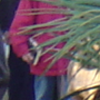

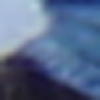

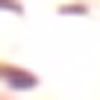

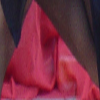

In [ ]:
boxes = []
proposals = []
for (x, y, w, h) in rects[:5]:
  roi = image[y:y + h, x:x + w]
  roi = cv2.resize(roi, (100,100),
		interpolation=cv2.INTER_CUBIC)
  cv2_imshow(roi)
  boxes.append((y/height, x/width, (y + h)/height, (x + w)/width))

In [ ]:
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img = img_to_array(img)
img = tf.expand_dims(img, 0)
box_tensor = tf.convert_to_tensor(boxes)
box_tensor = tf.expand_dims(box_tensor, 0)
l = RoiPooling(100)
o = l([img, box_tensor])

5


In [ ]:
o = tf.squeeze(o)

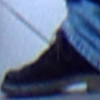

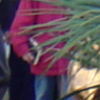

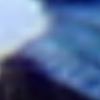

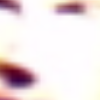

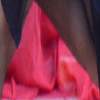

In [ ]:
from tensorflow.keras.preprocessing.image import array_to_img
import numpy as np

for i in range(len(o)):
  roi = array_to_img(o[i].numpy()[...,::-1])
  roi = np.float64(roi)
  cv2_imshow(roi)